In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import pickle

from sklearn.metrics.pairwise import cosine_similarity
    
os.chdir("C:\\Users\\SJNic\\Documents\\University\\Master\\Thesis\\Thesis Code")

# Read the new files
with open("NewProcessingData/documentsInformation.txt", "rb") as fp:   
    documentsInformation = pickle.load(fp)
# the file containing the ground truth
with open("Besluithistorie/historieDocs.txt", "rb") as fp:
    historieDocs = pickle.load(fp)
    
lemmas = pd.read_pickle("Similarities/newLemmas.pkl")

In [2]:
# loading the embeddings
document_embeddings = np.load("Similarities/document_embeddings.npy")

# First we still have to calculate the pairwise similarities

In [3]:
pairwise_similarities=cosine_similarity(document_embeddings)
pairwise_similarities.shape

(44613, 44613)

In [4]:
# function for calculating the similarity between two vectors
def most_similar(docID, similarity_matrix, threshold, printing = False):
    if printing:
        print (f'Document: {lemmas.iloc[docID]["lemmas"][0:40]}')
        print ('Similar Documents:')
    
    most_related_docs = []
    relevance_scores = []
    
    # sort the documents
    similar_ix=np.argsort(similarity_matrix[docID])[::-1]
    
    # loop through the sorted docuemnts
    for ix in similar_ix:
        
        # if it is the same doc skip
        if ix==docID:
            continue
        
        # because the docs are sorted, if the similarity is below the threshold then all after are also worthless, so break out of the loop
        if similarity_matrix[docID][ix] <= threshold:
            break
            
        else:       
            # get the document id of this relevant doc
            docBID = lemmas.index[ix]
            
            # append the reference to the unique version of this doc
            most_related_docs.append(documentsInformation[docBID]["unique id"])
            relevance_scores.append(similarity_matrix[docID][ix])

            if printing:
                print("______________________________________________________________________________________________")
                print(f"DOC ID: {docBID}")
                print(f"DOC loc: {lemmas.index.get_loc(docBID)}")
                #print("test", docID, ix, similarity_matrix)
                print (f'Similarity score : {similarity_matrix[docID][ix]}')
                print (f'Text preview: {lemmas.iloc[ix]["lemmas"][0:40]}')
        
    return (most_related_docs, relevance_scores)

# Relevance assessment with multiple documents

In [5]:
with open("Besluithistorie/Thomas/historieProposalDocs.txt", "rb") as fp:
    historieProposalDocs = pickle.load(fp)

# initiatiefvoorstel verbod afsteken consumenten vuurwerk toevoegen
historieProposalDocs["898ad2c2-058c-496f-90e6-8e5710e1ed7a"] = {"itemTitle": "Initiatiefvoorstel verbod afsteken consumentenvuurwerk",
                                                               "itemID": "898ad2c2-058c-496f-90e6-8e5710e1ed7a",
                                                               "docs": [documentsInformation["e441f0bc-ec02-4c1b-8932-039a89d22235"]["unique id"],
                                                                       documentsInformation["b22b9519-608b-4c9c-9240-2865cd421d6c"]["unique id"],
                                                                       documentsInformation["b157f358-5664-447d-b009-5f3f53b367e3"]["unique id"],
                                                                       documentsInformation["0d0dda63-acd1-46ff-b7b9-d9e6e272226c"]["unique id"],
                                                                       documentsInformation["cc2a839b-4d78-4421-9f9b-f4cf83f752b4"]["unique id"]
                                                                       ]}

In [6]:
chosenKeys = ["e638d5f8-f0e8-44b0-9168-bde292150c73", #0
              "a422f486-9b68-40f9-ab84-af7c1fde9017",#1
              "4055759c-8f5a-46fa-829a-6127b09e3d5a",#2
              "29834557-37a8-46e3-ad9e-cf06d79a478a",#3
              "46b9aabe-3958-4b6f-833e-051c9aefcc6a",#4
              "20dbf3a0-f651-4259-975a-3bc8013604b5",#5
              "c3c160ca-3942-46da-8b28-564dab94f9fc",#6
              "898ad2c2-058c-496f-90e6-8e5710e1ed7a",#7 
              "6328dc36-607d-4c00-a35c-9d6cc548a07e",# 8
              "009fd1d9-dc31-4086-8132-18c568b0db61"]# 9

In [9]:
related_docs = most_similar(lemmas.index.get_loc(chosenKeys[0]), pairwise_similarities, 0.3)
len(related_docs)

2

In [25]:
finding_docs_failures = 0 # only 56 documents could not be found


for key in [chosenKeys[9]]:
    historieInfo = historieProposalDocs[key]
    #print(historieInfo)
    
    # create a df which can be used for sorting
    sorting_df = pd.DataFrame(columns=["doc name", "Relevance", "url"])
    sorting_df["url"] = ""
    
    # loop through all docs attached to this proposal with the decision history
    for docID in historieInfo["docs"]:
        print(documentsInformation[docID]["displayname"])
        
        # sometimes finding a doc fails, so in that case skip it
        try: 
            related_docs = most_similar(lemmas.index.get_loc(docID), pairwise_similarities, 0.5)
        except:
            finding_docs_failures+=1
        
        # loop through all the documents that are found to be relevant
        for i in range(len(related_docs[0])):
            doc = related_docs[0][i]
            score = related_docs[1][i]
            
            # if it is an already known document then skip it
            if doc in docID:
                continue
                
            if "dossier" in documentsInformation[doc]["displayname"].lower() or "link naar ro" in documentsInformation[doc]["displayname"].lower() or "niet-toepasselijkheid" in documentsInformation[doc]["displayname"].lower():
                continue
            
            # if this doc not yet in the df then add it
            if doc not in sorting_df.index:
                sorting_df.loc[doc] = [documentsInformation[doc]["displayname"], score, documentsInformation[doc]["publicdownloadurl"]]
            
            # oterwise see if the score should be update
            else:
                if score > sorting_df.loc[doc]["Relevance"]:
                    sorting_df.loc[doc, "Relevance"] = score
    
    break
pd.set_option('display.max_colwidth', None)
sorting_df.sort_values("Relevance", ascending = False).head(60)

Dossier 667 voorblad.pdf
Voorstel_11755.pdf
Actieprogramma Samen stad maken op de Utrechtse manier
Praatplaat Samen stad maken op de Utrechtse manier
Participatie -en inspraakverordening
toelichting Participatieverordening
Aangepaste Participatie en inspraakverordening met wijzingen bijgehouden
Besluitenhistorie participatie 25 juni 2019


,doc name,Relevance,url
1f0e0aa7-3a72-45a0-bf69-7abd859e3ca3,Aangepaste Participatie en inspraakverordening met wijzingen bijgehouden,0.959564,https://api1.ibabs.eu/publicdownload.aspx?site=Utrecht&id=1f0e0aa7-3a72-45a0-bf69-7abd859e3ca3
2564151d-a976-477c-8576-50038a508077,Participatie -en inspraakverordening,0.959564,https://api1.ibabs.eu/publicdownload.aspx?site=Utrecht&id=2564151d-a976-477c-8576-50038a508077
b9030f32-57aa-4ae4-a4d8-3b8518ce9182,Voorstel_11755,0.952418,https://api1.ibabs.eu/publicdownload.aspx?site=Utrecht&id=b9030f32-57aa-4ae4-a4d8-3b8518ce9182
b7acefc6-03db-4c8c-b095-f42d9777c80f,ConceptParticipatie-eninspraakverordeningmei2013,0.914931,https://api1.ibabs.eu/publicdownload.aspx?site=Utrecht&id=b7acefc6-03db-4c8c-b095-f42d9777c80f
2ac2be85-08fe-44e6-a052-a2adfd7e87a5,Bijlage 3 Concept Participatie- en inspraakverordening mei 2013,0.911070,https://api1.ibabs.eu/publicdownload.aspx?site=Utrecht&id=2ac2be85-08fe-44e6-a052-a2adfd7e87a5
1a58896c-e69e-4d2e-9737-7bd6696e81d4,Bijlage 4 Inspraakverordening - toelichting,0.910696,https://api1.ibabs.eu/publicdownload.aspx?site=Utrecht&id=1a58896c-e69e-4d2e-9737-7bd6696e81d4
71783fe8-9b19-4ad7-b33b-189c6aab6348,Bijlage 9 Concept Herziene Inspraak- en participatieverordening plus toelichting,0.898890,https://api1.ibabs.eu/publicdownload.aspx?site=Utrecht&id=71783fe8-9b19-4ad7-b33b-189c6aab6348
85105ee4-db2b-46a6-a31b-fac25bd3578d,Bijlage 3 Concept toelichting verordening Utrechtse Participatiestandaard,0.892829,https://api1.ibabs.eu/publicdownload.aspx?site=Utrecht&id=85105ee4-db2b-46a6-a31b-fac25bd3578d
c500e4b9-d719-4c31-9382-f8f0ce56c8a4,Bijlage 5 Inspraakverordening 8 april 2010 Gemeenteblad van Utrecht 2010 nr34,0.890620,https://api1.ibabs.eu/publicdownload.aspx?site=Utrecht&id=c500e4b9-d719-4c31-9382-f8f0ce56c8a4
fd19dd02-ab40-4e26-93ae-5797de9d77e7,Inspraakverordening8april2010GemeentebladvanUtrecht2010nr34,0.876164,https://api1.ibabs.eu/publicdownload.aspx?site=Utrecht&id=fd19dd02-ab40-4e26-93ae-5797de9d77e7


In [5]:
list(historieDocs.keys())[0]

'009fd1d9-dc31-4086-8132-18c568b0db61'

In [6]:
documentsInformation["009fd1d9-dc31-4086-8132-18c568b0db61"]["unique id"]

'8369220c-93f4-4580-a914-631e81063818'

In [7]:
lemmas.index.get_loc("8369220c-93f4-4580-a914-631e81063818")

22696

In [8]:
pairwise_similarities[22696]

array([ 0.20882414, -0.13459737,  0.06678233, ...,  0.01393892,
        0.08730761,  0.14601129])

In [29]:
key = "8369220c-93f4-4580-a914-631e81063818"

related_docs = most_similar(lemmas.index.get_loc(key), pairwise_similarities, 0.3)

test = {}

for i in range(0,15):
    doc = related_docs[0][i]
    docInfo = documentsInformation[doc]
    #print(docInfo)
    #print(f"{i} Document name: \t{docInfo['displayname']}")
    #print(f"{i} Download url: \t{docInfo['publicdownloadurl']}")
    
    test[i+1] = [docInfo['displayname'], related_docs[1][i], docInfo['publicdownloadurl']]

pd.set_option('display.max_colwidth', -1)
test = pd.DataFrame.from_dict(test).T
test

<ipython-input-29-2cc29243b395>:16: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,0,1,2
1,Voorstel_11755,0.646522,https://api1.ibabs.eu/publicdownload.aspx?site=Utrecht&id=b9030f32-57aa-4ae4-a4d8-3b8518ce9182
2,Voorstel_11755.pdf,0.634609,https://api1.ibabs.eu/publicdownload.aspx?site=Utrecht&id=497a1cd2-92fb-4ad6-a3f6-ec632c3f6a32
3,Raadsbrief Samen stad maken op de Utrechtse manier.docx,0.609897,https://api1.ibabs.eu/publicdownload.aspx?site=Utrecht&id=ce37637e-cdf2-48dc-8f62-398e845729d2
4,Raadsbrief Schriftelijke beantwoording 1e termijn actieprogramma Samen stad maken.pdf,0.56939,https://api1.ibabs.eu/publicdownload.aspx?site=Utrecht&id=97040ddb-5d74-403d-86cb-f4c8c04cec5f
5,Motie 155 ciebrief MS 20160420,0.525048,https://api1.ibabs.eu/publicdownload.aspx?site=Utrecht&id=72497186-bcce-4b1d-8565-c2eec8b9fbe4
6,Raadsvoorstel: Samen voor de wijk inzicht in de adviesrelatie tussen de wijkraden en de gemeente Utrecht,0.519571,https://api1.ibabs.eu/publicdownload.aspx?site=Utrecht&id=62a1ecc8-6733-4fa4-b4ac-fa81f705a60e
7,Raadsbrief Terugkoppeling Al doende vernieuwen van de wijkparticipatie.docx,0.517293,https://api1.ibabs.eu/publicdownload.aspx?site=Utrecht&id=ccf86a21-755c-402a-99f5-62a687dbf043
8,Raadsmemo Toezegging 1515 online participatie.docx,0.514244,https://api1.ibabs.eu/publicdownload.aspx?site=Utrecht&id=f4e2f461-8743-4c85-a2fe-340a529cf926
9,Raadsbrief Schriftelijke beantwoording 1e termijn actieprogramma Samen stad maken.docx,0.51175,https://api1.ibabs.eu/publicdownload.aspx?site=Utrecht&id=0e4554d2-9510-48ee-bf0e-a7596c30ef0c
10,Startnotitie bundeling advies- en cliëntraden,0.509667,https://api1.ibabs.eu/publicdownload.aspx?site=Utrecht&id=b8649e7c-2a3f-47df-8ef9-23009acbbf77


## Relevance assessment

In [ ]:
key = ""
related_docs = most_similar(key, 0.0, False) 

test = {}

for i in range(0,15):
    
    doc = related_docs[0][i]
    docInfo = documentsInformation[doc]
    #print(f"{i} Document name: \t{docInfo['displayname']}")
    #print(f"{i} Download url: \t{docInfo['publicdownloadurl']}")
    
    test[i+1] = [docInfo['displayname'], related_docs[1][i], docInfo['publicdownloadurl']]

pd.set_option('display.max_colwidth', -1)
test = pd.DataFrame.from_dict(test).T
test

# Sensitivty analysis

In [16]:
def CalculateScores(histories, df, threshold, printing = False, example = False):
    # total True positives, False positives, True negatives, False negatives
    total_TP = []
    total_FP = []
    total_TN = []
    total_FN = []
    
    missed_docs = 0
    
    # loop through every historie in the histories
    for key in histories:
        # scores for this run
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        
        # get the documents belonging to this historie + the key to the historie itself
        histDocIDs =  histories[key]
        
        # get the unique version of this besluithistorie doc
        key = documentsInformation[key]["unique id"]
        #histDocIDs  = histDocIDs + [key]
        
        #print(histDocIDs)
        if example:
            print("Historie documents")
            for histDocID in histDocIDs:
                print(histDocID, documentsInformation[histDocID]["displayname"])
        
        # sometimes the documents cannot be found
        try:
            # get the docs related to this historie according to the given df            
            resultsDocIDs = most_similar(lemmas.index.get_loc(key), df, threshold)
            
            if example:
                print("\n\nRelated documents:")
                for resultDocID in resultsDocIDs:
                    print(resultDocID, documentsInformation[resultDocID]["displayname"])
            
        except:
            missed_docs+=1
        
        # the same list of docs as the historie, but we use this one to calculate the false negatives
        docs_matched = 0
        
        if example:
            print("\nMatches")
        # loop through the docIDs to calculate the scores
        for resultDocID in resultsDocIDs:
            
            # True positive
            if resultDocID in histDocIDs:
                TP += 1
                docs_matched +=1
                
                if example:
                    print("Matching doc: ",documentsInformation[resultDocID]["displayname"])
            # false positives
            else :
                FP += 1
        
        # The false negatives are equal to the number of documents we have not found
        FN += len(histDocIDs) - docs_matched
        
        # True negatives is equal to every document not found by the method which should also not be found
        TN += len(documentsInformation) - TP - FP - FN
        
        # add the new values
        total_TP.append(TP)
        total_FP.append(FP)
        total_TN.append(TN)
        total_FN.append(FN)
        
        if example:
            break
    
    precision = np.sum(total_TP) / (np.sum(total_TP) + np.sum(total_FP))
    recall = np.sum(total_TP) / (np.sum(total_TP) + np.sum(total_FN))
    
    if printing:
        print("_________________________________________________________________________________")
        print("Score\t\t\tTotal\t\tMean")
        print(f"True positives:\t\t{np.sum(total_TP)}\t\t{np.mean(total_TP)}")
        print(f"False positives:\t{np.sum(total_FP)}\t\t{np.mean(total_FP)}")
        print(f"True negatives:\t\t{np.sum(total_TN)}\t\t{np.mean(total_TN)}")
        print(f"False negatives:\t{np.sum(total_FN)}\t\t{np.mean(total_FN)}")
        print("")
        
        print(f"Precision:\t\t{precision}")
        print(f"Recall:\t\t\t{recall}")
    
    return (precision, recall)
    #return (total_TP, total_FP, total_TN, total_FN)
scores = CalculateScores(historieDocs, pairwise_similarities, 0.5, True, True)

Historie documents
ccf86a21-755c-402a-99f5-62a687dbf043 Raadsbrief Terugkoppeling Al doende vernieuwen van de wijkparticipatie.docx
67331aa8-98db-4791-adb7-74be1962a5fb Raadsbrief Beantwoording motie 23 - Democratie verbreden en verbeteren.docx
ce37637e-cdf2-48dc-8f62-398e845729d2 Raadsbrief Samen stad maken op de Utrechtse manier.docx
0df6daf8-b9fc-4137-8cb1-60215f5eb3a2 Uitnodiging raad vernieuwing wijkparticipatie
526b4dab-78a8-4f91-98f1-c20c4c67cf93 Raadsbrief Vernieuwen wijkparticipatie
72497186-bcce-4b1d-8565-c2eec8b9fbe4 Motie 155 ciebrief MS 20160420
dbbc2c82-24fa-4d51-8caa-5c13468c6d70 Raadsbrief vernieuwing van wijkparticipatie..docx


Related documents:
b9030f32-57aa-4ae4-a4d8-3b8518ce9182 Voorstel_11755
497a1cd2-92fb-4ad6-a3f6-ec632c3f6a32 Voorstel_11755.pdf
ce37637e-cdf2-48dc-8f62-398e845729d2 Raadsbrief Samen stad maken op de Utrechtse manier.docx
97040ddb-5d74-403d-86cb-f4c8c04cec5f Raadsbrief Schriftelijke beantwoording 1e termijn actieprogramma Samen stad maken.pdf
724

In [17]:
# sensitivity analysis
precision_scores = []
recall_scores = []

steps = 200

for i in tqdm(range(steps)):
    scores = CalculateScores(historieDocs, pairwise_similarities, i / steps)
    precision_scores.append(scores[0])
    recall_scores.append(scores[1])

 97%|█████████▋| 194/200 [03:55<00:01,  5.94it/s]<ipython-input-16-82782e0c1fe3>:78: RuntimeWarning: invalid value encountered in long_scalars
  precision = np.sum(total_TP) / (np.sum(total_TP) + np.sum(total_FP))
100%|██████████| 200/200 [03:56<00:00,  1.18s/it]


# save the scores
with open("Evaluation/doc2vecPrecision.txt", "wb") as fp:
    pickle.dump(precision_scores, fp)
with open("Evaluation/doc2vecRecall.txt", "wb") as fp:
    pickle.dump(recall_scores, fp)

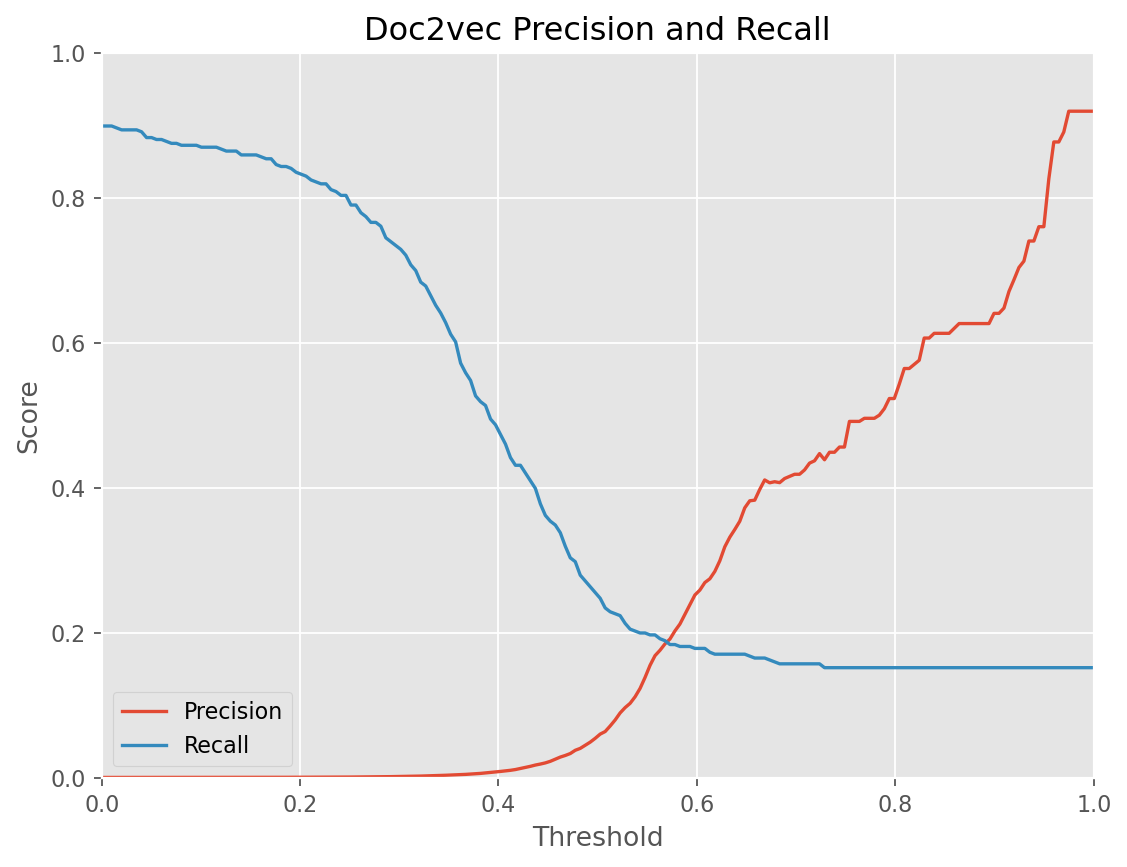

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

#plt.style.use('seaborn-whitegrid')
plt.style.use('ggplot')
#plt.style.use('science')

figure(figsize=(8, 6), dpi=160)

x = np.linspace(0, 1, steps)
plt.plot(x, precision_scores, label = "Precision")
plt.plot(x, recall_scores, label = "Recall")

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Doc2vec Precision and Recall")

plt.legend()

#plt.savefig("Evaluation/doc2vec.png")

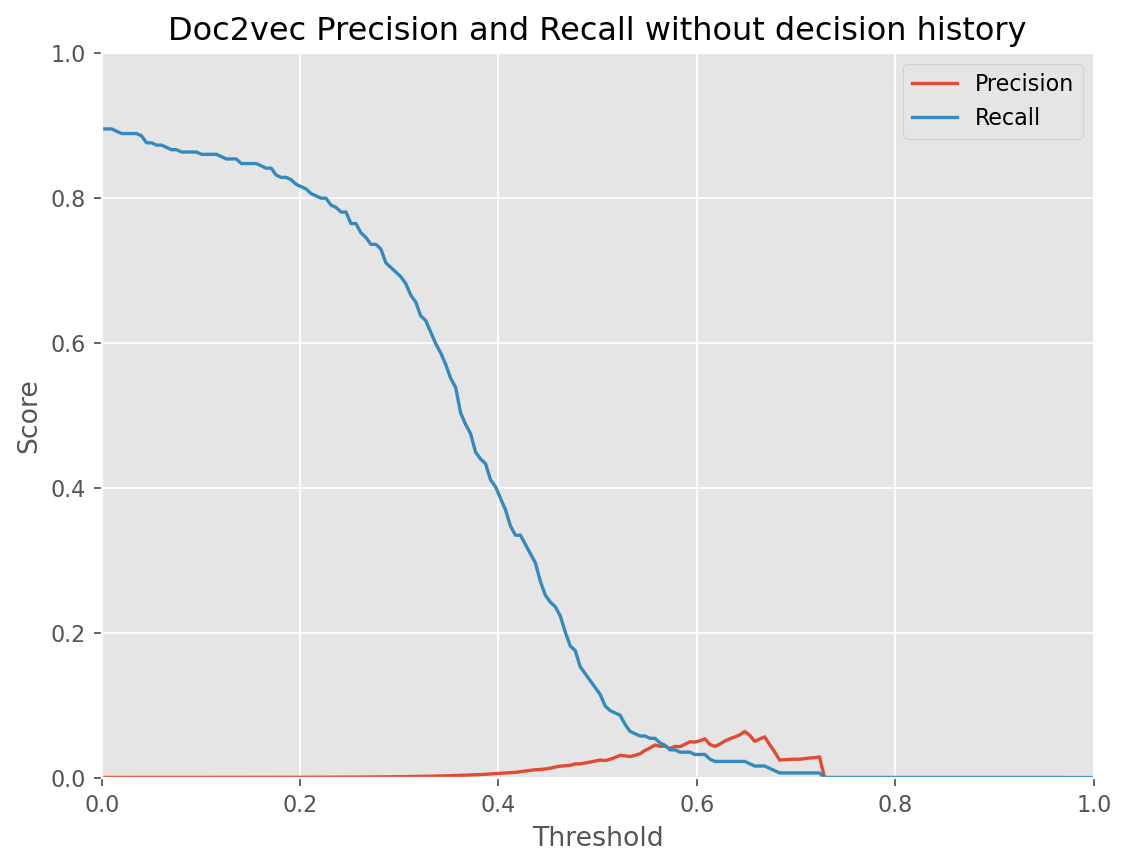

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

#plt.style.use('seaborn-whitegrid')
plt.style.use('ggplot')
#plt.style.use('science')

figure(figsize=(8, 6), dpi=160)

x = np.linspace(0, 1, steps)
plt.plot(x, precision_scores, label = "Precision")
plt.plot(x, recall_scores, label = "Recall")

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Doc2vec Precision and Recall without decision history")

plt.legend()

#plt.savefig("Evaluation/doc2vec-minusbesluithistorie.png")

In [20]:
# save the scores
with open("Evaluation/doc2vecPrecision-minusdecisionhistory.txt", "wb") as fp:
    pickle.dump(precision_scores, fp)
with open("Evaluation/doc2vecRecall-minusdecisionhistory.txt", "wb") as fp:
    pickle.dump(recall_scores, fp)